# House Prices: Advanced Regression Techniques

With the following notebook I have implemented a Neural Network that creates Embeddings out of Categorical Features proven to improve performance.

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F

In [11]:
df=pd.read_csv('train.csv',usecols=["SalePrice", "MSSubClass", "MSZoning", "LotFrontage", "LotArea",
                                         "Street", "YearBuilt", "LotShape", "1stFlrSF", "2ndFlrSF"]).dropna()
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,YearBuilt,1stFlrSF,2ndFlrSF,SalePrice
0,60,RL,65.0,8450,Pave,Reg,2003,856,854,208500
1,20,RL,80.0,9600,Pave,Reg,1976,1262,0,181500
2,60,RL,68.0,11250,Pave,IR1,2001,920,866,223500
3,70,RL,60.0,9550,Pave,IR1,1915,961,756,140000
4,60,RL,84.0,14260,Pave,IR1,2000,1145,1053,250000


In [4]:
df.shape

(1201, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1201 entries, 0 to 1459
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MSSubClass   1201 non-null   int64  
 1   MSZoning     1201 non-null   object 
 2   LotFrontage  1201 non-null   float64
 3   LotArea      1201 non-null   int64  
 4   Street       1201 non-null   object 
 5   LotShape     1201 non-null   object 
 6   YearBuilt    1201 non-null   int64  
 7   1stFlrSF     1201 non-null   int64  
 8   2ndFlrSF     1201 non-null   int64  
 9   SalePrice    1201 non-null   int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 103.2+ KB


### Unique Value Count

In [21]:
pd.DataFrame(data=[[col,len(df[col].unique())] for col in df.columns],columns=['Feature','Unique Items']).style.background_gradient()

,Feature,Unique Items
0,MSSubClass,15
1,MSZoning,5
2,LotFrontage,110
3,LotArea,869
4,Street,2
5,LotShape,4
6,YearBuilt,112
7,1stFlrSF,678
8,2ndFlrSF,368
9,SalePrice,597


# Data Preprocessing

In [32]:
df['YearsSinceBuilt'] = datetime.datetime.now().year - df.YearBuilt
df.drop('YearBuilt',axis=1,inplace=True)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,1stFlrSF,2ndFlrSF,SalePrice,YearsSinceBuilt
0,5,3,65.0,8450,1,3,856,854,208500,17
1,0,3,80.0,9600,1,3,1262,0,181500,44
2,5,3,68.0,11250,1,0,920,866,223500,19
3,6,3,60.0,9550,1,0,961,756,140000,105
4,5,3,84.0,14260,1,0,1145,1053,250000,20


In [22]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'SalePrice',
       'YearsSinceBuilt'],
      dtype='object')

## Handling Categorical Features

In [23]:
cat_features = ['MSSubClass', 'MSZoning','Street','LotShape', ]

In [25]:
lblEncoders = {}
for feature in cat_features:
    lblEncoders[feature] = LabelEncoder()
    df[feature] = lblEncoders[feature].fit_transform(df[feature])

In [26]:
catTensor = np.stack([df[col] for col in cat_features],1)
catTensor = torch.tensor(catTensor,dtype=torch.int64)
catTensor

tensor([[5, 3, 1, 3],
        [0, 3, 1, 3],
        [5, 3, 1, 0],
        ...,
        [6, 3, 1, 3],
        [0, 3, 1, 3],
        [0, 3, 1, 3]])

## Handling Continuos Features

In [90]:
cont_features = [col for col in df.columns if col not in cat_features and col!= 'SalePrice']
cont_features 

['LotFrontage', 'LotArea', '1stFlrSF', '2ndFlrSF', 'YearsSinceBuilt']

In [91]:
contTensor = np.stack([df[col] for col in cont_features],axis=1)
contTensor = torch.tensor(contTensor,dtype=torch.float)
contTensor

tensor([[   65.,  8450.,   856.,   854.,    17.],
        [   80.,  9600.,  1262.,     0.,    44.],
        [   68., 11250.,   920.,   866.,    19.],
        ...,
        [   66.,  9042.,  1188.,  1152.,    79.],
        [   68.,  9717.,  1078.,     0.,    70.],
        [   75.,  9937.,  1256.,     0.,    55.]])

##### Dependant Feature

In [92]:
y = torch.tensor(df['SalePrice'].values,dtype=torch.float).reshape(-1,1)
y

tensor([[208500.],
        [181500.],
        [223500.],
        ...,
        [266500.],
        [142125.],
        [147500.]])

# Categorical Embeddings 
At most 50 categorical features to be implemented, thus we are following `min(50 , (dimension+1)//2)` Rule

In [93]:
cat_dims = [len(df[col].unique()) for col in cat_features]
embedding_dims = [(dim,min(50,(dim+1)//2)) for dim in cat_dims]
embedding_dims

[(15, 8), (5, 3), (2, 1), (4, 2)]

In [94]:
embed_repr = nn.ModuleList([nn.Embedding(inp,out) for inp,out in embedding_dims])
embed_repr

ModuleList(
  (0): Embedding(15, 8)
  (1): Embedding(5, 3)
  (2): Embedding(2, 1)
  (3): Embedding(4, 2)
)

In [95]:
embed_values = []
for i,e in enumerate(embed_repr):
    embed_values.append(e(catTensor[:,i]))

In [96]:
embed_values = torch.cat(embed_values,1)
embed_values

tensor([[ 0.9849, -1.6149,  0.2978,  ...,  0.7049,  0.7470, -0.3021],
        [-0.6772,  1.0859, -1.1900,  ...,  0.7049,  0.7470, -0.3021],
        [ 0.9849, -1.6149,  0.2978,  ...,  0.7049, -0.4365, -0.9372],
        ...,
        [-2.2952,  0.3509, -1.5490,  ...,  0.7049,  0.7470, -0.3021],
        [-0.6772,  1.0859, -1.1900,  ...,  0.7049,  0.7470, -0.3021],
        [-0.6772,  1.0859, -1.1900,  ...,  0.7049,  0.7470, -0.3021]],
       grad_fn=<CatBackward>)

##### Adding Regularization to Embeddings using Dropout

In [97]:
embed_values = nn.Dropout(.4)(embed_values)
embed_values

tensor([[ 0.0000, -0.0000,  0.0000,  ...,  1.1749,  0.0000, -0.5035],
        [-0.0000,  1.8099, -1.9834,  ...,  0.0000,  1.2450, -0.0000],
        [ 1.6415, -2.6915,  0.0000,  ...,  1.1749, -0.0000, -0.0000],
        ...,
        [-3.8254,  0.0000, -2.5817,  ...,  0.0000,  1.2450, -0.0000],
        [-1.1286,  1.8099, -1.9834,  ...,  1.1749,  0.0000, -0.5035],
        [-1.1286,  1.8099, -1.9834,  ...,  1.1749,  1.2450, -0.5035]],
       grad_fn=<MulBackward0>)

# Building Neural Network Architecture

In [119]:
class Model(nn.Module):
    def __init__(self, embedding_dim, n_cont, out_sz, layers, drop=0.5):
        super().__init__()
        self.embed_repr = nn.ModuleList([nn.Embedding(inp,out) for inp,out in embedding_dims])
        self.embed_dropout = nn.Dropout(drop)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((val[1] for val in embedding_dim))
        n_in = n_cont + n_emb
        
        for layer in layers:
            layerlist.append(nn.Linear(n_in,layer))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(layer))
            layerlist.append(nn.Dropout(drop))
            n_in = layer
        layerlist.append(nn.Linear(layers[-1],out_sz))
        
        self.layers = nn.Sequential(*layerlist)
        
    def forward(self, cat,cont):
        embeddings = []
        for i,e in enumerate(self.embed_repr):
            embeddings.append(e(cat[:,i]))
        x = torch.cat(embeddings,1)
        x = self.embed_dropout(x)
        x_cont = self.bn_cont(cont)
        x = torch.cat([x,x_cont],1)
        x = self.layers(x)
        return x

In [120]:
torch.manual_seed(100)
model = Model(embedding_dims, len(cont_features), 1, [100,50], drop = .4)

In [121]:
model

Model(
  (embed_repr): ModuleList(
    (0): Embedding(15, 8)
    (1): Embedding(5, 3)
    (2): Embedding(2, 1)
    (3): Embedding(4, 2)
  )
  (embed_dropout): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=19, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [122]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr =0.01)

# Model Training

In [123]:
batch_size = len(df)
test_size = int(batch_size*.15)
train_cat = catTensor[:batch_size-test_size]
test_cat = catTensor[batch_size-test_size:batch_size]
train_cont = contTensor[:batch_size-test_size]
test_cont = contTensor[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [124]:
len(test_cat)

180

In [128]:
epochs = 5000
losses = []
for i in range(epochs):
    i += 1
    y_pred = model.forward(train_cat,train_cont)
    loss = torch.sqrt(loss_function(y_pred,y_train))
    losses.append(loss)
    if i%50 == 0:
        print(f"Epoch {i} : {loss}")
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch 50 : 195423.671875
Epoch 100 : 194391.78125
Epoch 150 : 193250.96875
Epoch 200 : 192339.5625
Epoch 250 : 191125.984375
Epoch 300 : 189715.84375
Epoch 350 : 188490.4375
Epoch 400 : 187217.828125
Epoch 450 : 185637.671875
Epoch 500 : 184179.765625
Epoch 550 : 182613.765625
Epoch 600 : 181369.359375
Epoch 650 : 179351.65625
Epoch 700 : 177432.5625
Epoch 750 : 175856.953125
Epoch 800 : 174053.453125
Epoch 850 : 172078.5625
Epoch 900 : 170130.390625
Epoch 950 : 168139.546875
Epoch 1000 : 166029.40625
Epoch 1050 : 163681.625
Epoch 1100 : 162255.109375
Epoch 1150 : 159858.671875
Epoch 1200 : 157727.4375
Epoch 1250 : 155808.171875
Epoch 1300 : 152391.953125
Epoch 1350 : 151265.859375
Epoch 1400 : 147958.390625
Epoch 1450 : 146163.578125
Epoch 1500 : 143951.40625
Epoch 1550 : 141090.515625
Epoch 1600 : 138681.5625
Epoch 1650 : 136301.640625
Epoch 1700 : 134488.890625
Epoch 1750 : 131477.34375
Epoch 1800 : 128711.6640625
Epoch 1850 : 126530.6015625
Epoch 1900 : 124271.234375
Epoch 1950 : 1

Text(0.5, 0, 'epoch')

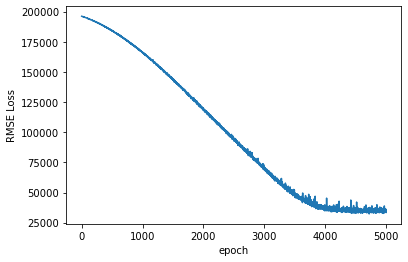

In [132]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch')

In [134]:
with torch.no_grad():
    y_pred=model(test_cat,test_cont)
    loss=torch.sqrt(loss_function(y_pred,y_test))
print('RMSE: {}'.format(loss))

RMSE: 44719.70703125
